In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy


In [2]:
landmarks = [[20.0, 20.0], [20.0, 80.0], [20.0, 50.0], [50.0, 20.0], [50.0, 80.0], 
             [80.0, 80.0], [80.0, 20.0], [80.0, 50.0]]

# map size in meters
world_size = 100.0
M_PI = 3.14
np.random.seed(123)

class Robot(object):
    def __init__(self):
        #  robot's pose
        self.x = np.random.rand() * world_size 
        self.y = np.random.rand()* world_size 
        self.orient = np.random.rand() * 2.0 * M_PI

        self.forward_noise = 0.0
        self.turn_noise = 0.0 
        self.sense_noise = 0.0 
        
    def set_val(self, new_x, new_y, new_orient):
        if (new_x < 0) or (new_x >= world_size):
            return("X coordinate out of bound")
        if (new_y < 0) or (new_y >= world_size):
            return("Y coordinate out of bound")
        if (new_orient < 0) or (new_orient >= 2 * M_PI):
            return("Orientation must be between zero and 2pi")
                    
        self.x = new_x
        self.y = new_y
        self.orient = new_orient
        
    def set_noise(self, new_forward_noise, new_turn_noise, new_sense_noise):
        # simulate noise for particle filters
        self.forward_noise = new_forward_noise
        self.turn_noise = new_turn_noise
        self.sense_noise = new_sense_noise
        
    def sense(self):
        # distances btw robot and the landmarks
        zs = list()
        for i in range(len(landmarks)):
            dist = np.sqrt(pow((self.x - landmarks[i][0]), 2) + pow((self.y - landmarks[i][1]), 2))
            dist += np.random.normal(0.0, self.sense_noise)
            zs.append(dist)
        
        return zs
    
    def move(self, turn, forward):
        
        if (forward < 0):
            print("Robot cannot move backward")

        # turn 
        self.orient = self.orient + turn + np.random.normal(0.0, self.turn_noise) # add randomness to turn cmd
        self.orient = np.mod(self.orient, 2 * M_PI)

        # move and 
        dist = forward + np.random.normal(0.0, self.forward_noise) # add randomness to motion cmd
        self.x = self.x + (np.cos(self.orient) * dist)
        self.y = self.y + (np.sin(self.orient) * dist)

        # cyclic truncate
        self.x = np.mod(self.x, world_size);
        self.y = np.mod(self.y, world_size);

        # set particle
        res = Robot()
        res.set_val(self.x, self.y, self.orient)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)

        return res
    
    def show_pose(self):
        return "x=" + str(self.x) + " y=" + str(self.y) + " orient=" + str(self.orient)
    
    
    def measurement_prob(self, measurement):
        # calculates how likely a measurement should be
        prob = 1.0
        for i in range(len(landmarks)):
            dist = np.sqrt(pow((self.x - landmarks[i][0]), 2) + pow((self.y - landmarks[i][1]), 2))
            prob *= self._gaussian(dist, self.sense_noise, measurement[i])
        return prob
    
    def _gaussian(self, mu, sigma, xm):
        # probability of x for 1-dim Gaussian
        return np.exp(-(pow((mu - xm), 2)) / (pow(sigma, 2)) / 2.0) / np.sqrt(2.0 * M_PI * (pow(sigma, 2)))

def evaluation(r, p, n):
    # calculate the mean error of the system
    sum_num = 0.0
    for tt in range(n):
        # note: cyclic world
        dx = np.mod((p[tt].x - r.x + (world_size / 2.0)), world_size) - (world_size / 2.0)
        dy = np.mod((p[tt].y - r.y + (world_size / 2.0)), world_size) - (world_size / 2.0)
        err = np.sqrt(pow(dx, 2) + pow(dy, 2))
        sum_num += err
    
    return sum_num / n


def visualize(n, robot, step, particles, resampled_particles):
    # draw the robot, landmarks, particles and resampled particles on a graph

    plt.xlim([0, 100])
    plt.ylim([0, 100])
    
    for i in range(n): 
        # draw particles in green
        plt.plot(particles[i].x, particles[i].y, "go")
        # draw resampled particles in cylan
        plt.plot(resampled_particles[i].x, resampled_particles[i].y, "co")

    
    # draw landmarks in red
    for l in range(len(landmarks)): 
        plt.plot(landmarks[l][0], landmarks[l][1], "ro")
    

    # draw robot position in blue
    plt.plot(robot.x, robot.y, "bo")

    # save the image and close the plot
    plt.savefig("./images/step" + str(step) + ".png")
    plt.clf()

    

In [3]:

if __name__ == "__main__":
  
    # create a set of particles
    n = 1000
    p = list()
    #p = np.empty(n, dtype=np.dtype(object))
    for i in range(n):
        p.append(Robot())
        p[i].set_noise(0.05, 0.05, 5.0)
      
  
    # re-initialize myrobot object 
    myrobot = Robot()
    #index_list = []

    # iterate over the set of particles
    steps = 50
    for t in range(steps):
        #index_list.append([])
        # move the robot and sense the environment afterwards
        myrobot = myrobot.move(0.1, 5.0)
        z = myrobot.sense()

        # simulate a robot motion for each of these particles
        p2 = list()
        for i in range(n):
            p2.append(Robot())
            p2[i] = p[i].move(0.1, 5.0)
            p[i] = copy.deepcopy(p2[i])
         

        # generate particle weights depending on robot's measurement
        #w = np.empty(n)
        w = list()
        for i in range(n): 
            w.append(p[i].measurement_prob(z))
         
        w = np.array(w)

        # resample the particles with a sample probability proportional to the importance weight
        p3 = list()
        for i in range(n):
            p3.append(Robot())
        
        index = int(np.random.rand() * n)

        beta = 0.0
        mw = w.max()
        
        for h in range(n): 
            beta += np.random.rand() * 2.0 * mw
            while (beta > w[index]):
                beta -= w[index]
                index = np.mod((index + 1), n)
               
                
            p3[h] = copy.deepcopy(p[index])
            #index_list[t].append(index)
            
        for k in range(n):
            p[k] = copy.deepcopy(p3[k])
  
        

        # evaluate the error
        msg = "Step = " + str(t) + ", Evaluation = " + str(evaluation(myrobot, p, n))
        print(msg)

        # visualize the position of the robot and the particles at each step
        visualize(n, myrobot, t, p2, p3);


Step = 0, Evaluation = 2.749980288919456
Step = 1, Evaluation = 3.5957838699173186
Step = 2, Evaluation = 3.5208603916061785
Step = 3, Evaluation = 3.5207133949239195
Step = 4, Evaluation = 3.768578223598064
Step = 5, Evaluation = 3.2535368831061886
Step = 6, Evaluation = 3.2888017184531635
Step = 7, Evaluation = 3.380729235659864
Step = 8, Evaluation = 3.49307028279367
Step = 9, Evaluation = 3.5308656204760354
Step = 10, Evaluation = 3.3656529291233874
Step = 11, Evaluation = 3.0416523222932805
Step = 12, Evaluation = 2.66600114945022
Step = 13, Evaluation = 2.439927638603685
Step = 14, Evaluation = 2.2651134368999335
Step = 15, Evaluation = 2.1207336663460508
Step = 16, Evaluation = 1.936968121588988
Step = 17, Evaluation = 1.8558673928519716
Step = 18, Evaluation = 1.7374797425106603
Step = 19, Evaluation = 1.6948338830820884
Step = 20, Evaluation = 1.6952200871197556
Step = 21, Evaluation = 1.6568467292417428
Step = 22, Evaluation = 1.6334360550113265
Step = 23, Evaluation = 1.5763

<Figure size 432x288 with 0 Axes>

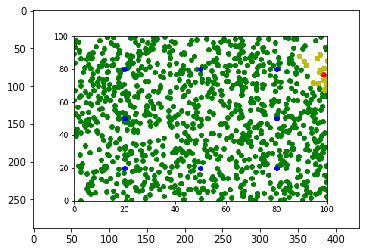

In [7]:
import cv2
step_0 = cv2.imread('images/step0.png')
plt.imshow(step_0)
plt.show()

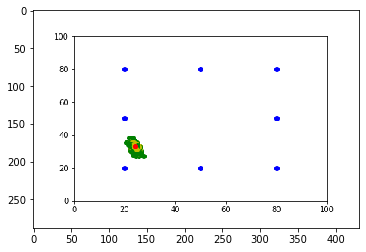

In [5]:
step_24 = cv2.imread('images/step24.png')
plt.imshow(step_24)
plt.show()

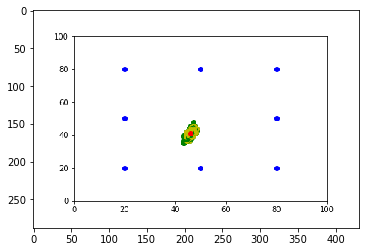

In [6]:
step_49 = cv2.imread('images/step49.png')
plt.imshow(step_49)
plt.show()